## Regret Matching
by [HydraulicSheep](https://github.com/HydraulicSheep)

Regret matching is a simple technique for finding Nash Equilibria in games. It can be broadly expanded to multi-turn, hidden-state games via the process of Counterfactual Regret Minimization.

References: 

* http://modelai.gettysburg.edu/2013/cfr/cfr.pdf

* https://blogs.cornell.edu/info2040/2014/09/12/applying-nash-equilibrium-to-rock-paper-and-scissors/


### Simple Regret Matching

Regret Matching underpins the concept of Regret Minimization. It involves assigning regrets based on how actions turned out compared with your choice - "a regret". This is then repeated for a number of iterations and the strategy converges to an equilibrium.

Let's give it a try with Rock Paper Scissors:

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now, let's initialize a simple bot class.

In [4]:
class RPSBot:
    
    def __init__():
        #0 initialisation to prevent dealing with later checks.
        self.strategy = [0,0,0]   #Stores the current strategy for selecting a move
        self.strategySum = [0,0,0] #Stores cumulative strategy over time. Normalizing this gives a converging strategy.
        self.regretSum = [0,0,0] #Stores sums of cumulative regrets associated with each move.
    

Now let's define some important methods. First, a way to update the strategy:

In [5]:
    def updateStrategy(self):
        totalWeight = 0  #Used to count total weights and normalize them to between 0 and 1.
        for i in range(len(self.strategy)):
            
            x = max(0,self.regretSum[i])  #We only keep non-negative regrets.
            totalWeight += x
            self.strategy[i] = x
            
        for i in range(len(self.strategy)): #3 actions so the list has length 3.
            
            if totalWeight>0:
                self.strategy[i] /= totalWeight #Normalises each weight
            else:
                self.strategy[i] = 1/len(self.strategy)  #If no strategy, assign equal weight.
                
            self.strategySum[i] += self.strategy[i]  #Adds this iteration's strategy to the total.
        

A strategy is just an array of probabilities - a distribution. To make a move, we simply sample over this distribution. Let's define a method to sample the strategy.

In [6]:
    def sampleStrategy(self):
        action = np.random.choice(np.arange(3),p=self.strategy)  #Choosing from array [0,1,2] 
        return action


Great! Conveniently, numpy will let us specify our distribution and then choose a number - 0,1,2 which represent the actions. Let's define them more clearly now.

In [7]:
#Let's make Rock = 0,  Paper = 1,  and Scissors = 2

Now, let's just add a method to return the average strategy (the thing which actually converges):

In [8]:
    def getAverageStrategy(self):
        averageStrategy = [0,0,0]
        totalWeight = 0
        for i in range(len(self.strategy)):
            totalWeight += self.strategySum[i]
        for i in range(len(self.strategy)):
            if totalWeight > 0:
                averageStrategy[i] = self.strategySum[i]/totalWeight
            else:
                averageStrategy[i] = 1/3
        return averageStrategy


Great! Technically the regret minimization part is now done. We just need to write a handler to run the games and compute the regrets for both bots.

In [9]:
def train(iterations,bot1,bot2):
    bot1data = []
    bot2data = []
    for i in range(iterations):
        utility1 = [0,0,0]
        utility2 = [0,0,0]
        # First we request moves from both bots
        
        bot1.updateStrategy()
        bot2.updateStrategy()
        
        action1 = bot1.sampleStrategy()
        action2 = bot2.sampleStrategy()
        
        # Then we compute the 'utility' scores of both moves
        
        utility1[action2] = 0
        utility2[action1] = 0
        
        #Now actions to the right beat their left neighnour. So they have utility 1
        
        utility1[(action2+1)%3] = 1
        utility2[(action1+1)%3] = 1
        
        #And actions to the left lose to their right neighbour. So they have utility -1
        
        utility1[(action2-1)%3] = -1
        utility2[(action1-1)%3] = -1
        
        #Update regretSum for bot1
        
        for x in range(len(utility1)):
            bot1.regretSum[x] += utility1[x] - utility1[action1]
        
            
        #And for bot2
        
        for y in range(len(utility2)):
            bot2.regretSum[y] += utility2[y] - utility2[action1]
            
        if i % 100 == 0:
            bot1data.append(bot1.getAverageStrategy()[0])
            bot2data.append(bot2.getAverageStrategy()[0])
            
    bot1series = pd.Series(bot1data,index=np.arange(0,iterations,100))
    bot2series = pd.Series(bot2data,index=np.arange(0,iterations,100))
    return bot1series, bot2series
        

So a training handler has been made, and the whole bot looks as follows:

In [10]:
class RPSBot:
    
    def __init__(self):
        self.strategy = [0,0,0] 
        self.strategySum = [0,0,0] 
        self.regretSum = [0,0,0]
        
    def updateStrategy(self):
        totalWeight = 0 
        for i in range(len(self.strategy)):
            
            x = max(0,self.regretSum[i])
            totalWeight += x
            self.strategy[i] = x
            
        for i in range(len(self.strategy)):
            
            if totalWeight>0:
                self.strategy[i] /= totalWeight
            else:
                self.strategy[i] = 1/len(self.strategy)
                
            self.strategySum[i] += self.strategy[i]
        
    def sampleStrategy(self):
        action = np.random.choice(np.arange(3),p=self.strategy)
        return action
        
    def getAverageStrategy(self):
        averageStrategy = [0,0,0]
        totalWeight = 0
        for i in range(len(self.strategy)):
            totalWeight += self.strategySum[i]
        for i in range(len(self.strategy)):
            if totalWeight > 0:
                averageStrategy[i] = self.strategySum[i]/totalWeight
            else:
                averageStrategy[i] = 1/3
        return averageStrategy


Now, let's specify a number of iterations and run! This was set at 1 million iterations and took about 30 seconds to run on laptop hardware:

0         0.333333
100       0.268842
200       0.281763
300       0.316494
400       0.355149
            ...   
999500    0.334217
999600    0.334283
999700    0.334350
999800    0.334416
999900    0.334483
Length: 10000, dtype: float64


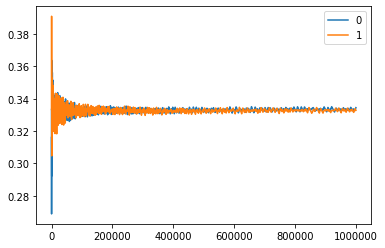

In [26]:
ITERATIONS = 1000000
bot1 = RPSBot()
bot2 = RPSBot()
bot1series, bot2series = train(ITERATIONS,bot1,bot2)
data = pd.concat([bot1series,bot2series],axis=1)
data.plot()
print(bot1series)

This graph plots just the Rock moves for players 1 and 2 (here 0 and 1) over iterations in the simulation. It is quite clear that these both converge to 0.33. This is what we expect from Rock Paper Scissors! There is a Nash Equilibrium at (1/3,1/3,1/3) and both bots iterate towards it.

Now, let's play around with it for a bit:

**What if ...** winning with **rock** feels extra satisfying and losing with **rock** is very saddening. Let's change the utility for those actions to **+2** and **-2**. 

*Note at how I've kept the posititve and negative weights equal to ensure that the game stays zero-sum. The reasons for this are touched on in the document referenced above*

In [36]:
def train(iterations,bot1,bot2):
    bot1data = []
    bot2data = []
    for i in range(iterations):
        utility1 = [0,0,0]
        utility2 = [0,0,0]
        # First we request moves from both bots
        
        bot1.updateStrategy()
        bot2.updateStrategy()
        
        action1 = bot1.sampleStrategy()
        action2 = bot2.sampleStrategy()
        
        # Then we compute the 'utility' scores of both moves
        
        utility1[action2] = 0
        utility2[action1] = 0
        
        #Now actions to the right beat their left neighnour. So they have utility 1
        
        if action1 == 0: 
            utility2[(action1+1)%3] = 2
        else:
            utility2[(action1+1)%3] = 1
         
        if action2 == 0: 
            utility1[(action2+1)%3] = 2
        else:
            utility1[(action2+1)%3] = 1

        #And actions to the left lose to their right neighbour. So they have utility -1
        
        if action1 == 0: 
            utility2[(action1-1)%3] = -2
        else:
            utility2[(action1-1)%3] = -1
         
        if action2 == 0: 
            utility1[(action2-1)%3] = -2
        else:
            utility1[(action2-1)%3] = -1
        
        #Update regretSum for bot1
        
        for x in range(len(utility1)):
            bot1.regretSum[x] += utility1[x] - utility1[action1]
        
            
        #And for bot2
        
        for y in range(len(utility2)):
            bot2.regretSum[y] += utility2[y] - utility2[action2]

            
        if i % 100 == 0:
            bot1data.append(bot1.getAverageStrategy()[0])
            bot2data.append(bot2.getAverageStrategy()[0])
            
    bot1series = pd.Series(bot1data,index=np.arange(0,iterations,100))
    bot2series = pd.Series(bot2data,index=np.arange(0,iterations,100))
    return bot1series, bot2series
        

0         0.333333
100       0.247316
200       0.211460
300       0.225005
400       0.235358
            ...   
999500    0.201093
999600    0.201073
999700    0.201052
999800    0.201032
999900    0.201012
Length: 10000, dtype: float64


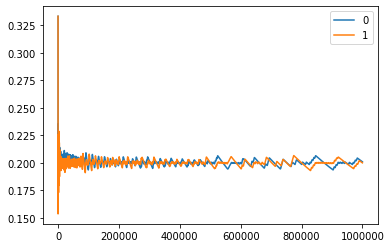

In [42]:
ITERATIONS = 1000000
bot1 = RPSBot()
bot2 = RPSBot()
bot1series, bot2series = train(ITERATIONS,bot1,bot2)
data = pd.concat([bot1series,bot2series],axis=1)
data.plot()
print(bot1series)

Now, this behaviour is interesting. Here the plot looks to converge to around 0.20. You might have expected that Rock, the action shown here, given its higher payoffs might have been more prevalent. Let's do some **calculations** to see why not:

First, let's define a payoff matrix for our game. If you're unfamiliar, each ordered pair represents the utility/payoff for an action: 

i.e. (**row player** payoff, **column player** payoff)


\begin{matrix}
     & \textbf{Rock} & \textbf{Paper} & \textbf{Scissors}\\
\textbf{Rock} & 0,0 & -2,2 & 2,-2 \\
\textbf{Paper} & 2,-2 & 0,0 & -1,1\\
\textbf{Scissors} & -2,2 & 1,-1 & 0,0 \\
\end{matrix}

As I specified, losing to and winning with rock are given extra weight.

Now, to find an equilibrium mixed strategy of all 3 actions, each player's expected utilities - E(U) - should be equal across all of their choices.

Let's examine expected values for the row player:

Let     $    \textbf{p}_{c,rock},\textbf{p}_{c,paper}, \textbf{p}_{c,scissors}   $     be the probabilities of the column player taking a certain action

From this, a linear system can be formed:

$$ E(Rock) = 0*{p}_{c,rock} + -2*{p}_{c,paper} + 2*{p}_{c,scissors} = 2*{p}_{c,rock} - 2*{p}_{c,paper} \quad [1]$$

$$ E(Paper) = 2*{p}_{c,rock} + 0*{p}_{c,paper} - 1*{p}_{c,scissors} = 2*{p}_{c,rock} - {p}_{c,scissors} \quad [2]$$

$$ E(Scissors) = -2*{p}_{c,rock} + 1*{p}_{c,paper} + 0*{p}_{c,scissors} = {p}_{c,paper} - 2*{p}_{c,rock} \quad [3]$$

And we can simplify by recognising $\textbf{p}_{c,rock} + \textbf{p}_{c,paper} +  \textbf{p}_{c,scissors} = 1$ - They form a strategy. And, by the statement above, row player expected values must all be equal: 

$$E(Rock) = E(Paper) = E(Scissors)$$

So, equating [3] and [2], we obtain:

$$ {p}_{c,paper} - 2*{p}_{c,rock} = 2*{p}_{c,rock} - {p}_{c,scissors}$$

$$ {p}_{c,paper} + {p}_{c,scissors} = 4*p_{c,rock}    \quad [4]$$  

$$ {p}_{c,paper} + {p}_{c,scissors} = 1 - {p}_{c,rock} \quad [5]$$

Substitute [5] into [4]:

$$ 1 = 5*p_{c,rock} $$

$$ p_{c,rock} = 1/5 $$

And look at that! Our calculated rock probability matches the value our simulated bots approach. It's a wonder that such a simple and intuitive concept - totalling 'regrets' - will converge to find an equilibrium mixed strategy.



And that's all for this notebook. Stay tuned to my ***Github*** - [HydraulicSheep](https://github.com/HydraulicSheep) - for explorations of more great ***Game Theory*** and ***Statistics*** content.